In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt 
import matplotlib
import pandas as pd
from collections import Counter
# pd.options.plotting.backend = 'plotly'
matplotlib.rcParams['font.family'] ='Malgun Gothic'

from datetime import timedelta
import datetime

In [2]:
# Collections of function

def load_data_and_set_date_state(start_date, end_date, data):
    '''
    Data load and drop na \n
    Setting start date and end date
    '''

    i=0
    # data = pd.read_csv('대한수학회 공유확진자DB_220321_' + str(i+1) + '.csv', low_memory=False)

    data = data[['거주시군구', '거주시도', '발병일', '신고일', '연령', '위중증 유무(유:1)', '사망유무(유:1)', '선행확진자_번호']]
    data.dropna(subset=['신고일'], axis=0, inplace=True)
    data.dropna(subset=['거주시도'], axis=0, inplace=True)
    data = data.fillna(0)
    data['신고일'] = pd.to_datetime(data['신고일'], format="%Y-%m-%d")
    data = data[(data['신고일'] >= pd.to_datetime(start_date, format="%Y-%m-%d")) & (data['신고일'] <= pd.to_datetime(end_date, format="%Y-%m-%d"))]
    data['확진자'] = [1]*len(data)
    return data

def load_data_and_set_date_city(start_date, end_date, data):
    '''
    Data load and drop na \n
    Setting start date and end date
    '''

    i=0
    # data = pd.read_csv('대한수학회 공유확진자DB_220321_' + str(i+1) + '.csv', low_memory=False)

    data = data[['거주시군구', '거주시도', '발병일', '신고일', '연령', '위중증 유무(유:1)', '사망유무(유:1)', '선행확진자_번호', '지역세분화']]
    data.dropna(subset=['신고일'], axis=0, inplace=True)
    data.dropna(subset=['지역세분화'], axis=0, inplace=True)
    data = data.fillna(0)
    data['신고일'] = pd.to_datetime(data['신고일'], format="%Y-%m-%d")
    data = data[(data['신고일'] >= pd.to_datetime(start_date, format="%Y-%m-%d")) & (data['신고일'] <= pd.to_datetime(end_date, format="%Y-%m-%d"))]
    data['확진자'] = [1]*len(data)
    return data

def make_dummy_date(start_date, end_date):
    '''
    Fill date of empty part
    '''

    start_y = int(start_date[0:4])
    start_m = int(start_date[5:7])
    start_d = int(start_date[8:10])
    end_y = int(end_date[0:4])
    end_m = int(end_date[5:7])
    end_d = int(end_date[8:10])

    diff_days = datetime.date(end_y,end_m,end_d) - datetime.date(start_y,start_m,start_d)
    
    date_list, week_list = [], []
    for i in range(diff_days.days+1): # +1 해줘야 지정한 날 마지막까지 감.
        date_list.append(datetime.date(start_y, start_m, start_d) + timedelta(days=i))
        
    for i in range(int(diff_days.days/7)):
        week_list.append(datetime.date(start_y, start_m, start_d) + timedelta(weeks=i))
        
    date_df = pd.DataFrame({'신고일' : date_list})
    week_df = pd.DataFrame({'신고주' : week_list})
    return date_df, week_df


def define_daily_dataframe(data, date_df, region, category):

    '''
    daily confirmed case and unlinked ratio
    '''
    if category == 'city':
        data = data[data['지역세분화'] == region]
    elif category == 'state':
        data = data[data['거주시도'] == region]
        
    data['신고일'] = data['신고일'].apply(lambda x: x.date())
    daily_data = pd.DataFrame({})
    daily_data['신고일'] = data['신고일'].value_counts().index
    daily_data['확진자'] = data['신고일'].value_counts().values
    
    unlinked_ratio = []
    for c_date in daily_data['신고일']:
        
        # 해당 신고일에 선행확진자 번호가 0인 사람을 카운트해서 비율로 추가
        tmp = data['선행확진자_번호'][data['신고일'] == c_date]
        unlinked_ = tmp.value_counts()[0]
        length = len(tmp)
        unlinked_ratio.append(unlinked_/length)
    
    # daily_data = preprocessing_01(daily_data, date_df, unlinked_ratio, region, region_idx, '신고일')
    daily_data = preprocessing_01(daily_data, date_df, unlinked_ratio, region, '신고일')
    # daily case는 연령별 추가 안해뒀음.
    return daily_data

def define_weekly_dataframe(data, week_df, region):
    
    '''
    weekly confirmed case and unlinked ratio
    '''
    weekly_data = pd.DataFrame({})
    week_case,week_date = [], []
    unlinked_ratio = []
    age_under_20 = []
    age_under_30 = []
    age_under_40 = []
    age_under_50 = []
    age_under_60 = []
    age_under_70 = []
    age_under_80 = []
    age_etc = []
     
    data = data[data['거주시도'] == region]
    data['신고일'] = data['신고일'].apply(lambda x: x.date())
    
    for w_date in week_df['신고주']:
        week_sum = ((data['신고일'] >= w_date) & (data['신고일'] < w_date + timedelta(weeks=1))).sum()
        week_case.append(week_sum)
        week_date.append(w_date)
        
    # weekly_data['신고주'] = week_date
    # weekly_data['확진자'] = week_case
    # for w_date in weekly_data['신고주']:
        
        tmp = data[(data['신고일'] >= w_date) & (data['신고일'] < w_date + timedelta(weeks=1))]
        
        age_group_list = add_age_group(tmp)
        age_under_20.append(age_group_list[0]/week_sum)
        age_under_30.append(age_group_list[1]/week_sum)
        age_under_40.append(age_group_list[2]/week_sum)
        age_under_50.append(age_group_list[3]/week_sum)
        age_under_60.append(age_group_list[4]/week_sum)
        age_under_70.append(age_group_list[5]/week_sum)
        age_under_80.append(age_group_list[6]/week_sum)
        age_etc.append(age_group_list[7]/week_sum)
        
        
        # 선행확진자 번호가 0인 사람이 없다면 unlinked ratio를 0으로, 아니라면 unlinked의 비율을 추가
        if len(tmp[tmp['선행확진자_번호'] == 0]) == 0:
            unlinked_ratio.append(0)
        else:
            unlinked_ = tmp['선행확진자_번호'].value_counts()[0]
            length = len(tmp)
            unlinked_ratio.append(unlinked_/length)
            
    weekly_data['신고주'] = week_date
    weekly_data['확진자'] = week_case
    weekly_data = preprocessing_01(weekly_data, week_df, unlinked_ratio, region, '신고주')
    weekly_data = preprocessing_02(weekly_data, age_under_20, age_under_30, age_under_40, age_under_50, age_under_60, age_under_70, age_under_80, age_etc)

    return weekly_data
    
def preprocessing_01(data, date_df, unlinked_ratio, region, sorting_criterion):
    ''' 
    daily, weekly data preprocessing and add unlinked case \n
    sorting_criterion = 신고일, 신고주
    '''

    # data['unlinked_ratio'] = unlinked_ratio
    # data['unlinked_ratio'].astype(float)
    
    data = pd.merge(data, date_df, how='outer')
    # data['거주시도'] = region # 번호로 해주니까 없어도 될듯
    # data['region_idx'] = region_idx # 이거도 필요없음
    data.fillna(0, inplace = True) # 날짜 합치면서 생기는 NaN 0으로 변환
    data.sort_values(by=sorting_criterion, inplace=True) # date 기준으로 sort
    data.index = [i for i in range(len(data))] # merge하면서 뒤죽박죽인 index를 다시 0부터
    # data['time_idx'] = [i for i in range(len(data))] # DeepAR 할때 필요한거
    
    # data.rename(columns = {sorting_criterion:'date', '확진자' : 'value'},inplace=True)
    data.rename(columns = {sorting_criterion:'date', '확진자' : region},inplace=True)
    del data['date']
    return data

def add_age_group(tmp):

    age_group_list = []
    age_group_list.append(len(tmp[tmp['연령'] < 20]))
    age_group_list.append(len(tmp[(tmp['연령'] < 30) & (tmp['연령'] >=20)]))
    age_group_list.append(len(tmp[(tmp['연령'] < 40) & (tmp['연령'] >=30)]))
    age_group_list.append(len(tmp[(tmp['연령'] < 50) & (tmp['연령'] >=40)]))
    age_group_list.append(len(tmp[(tmp['연령'] < 60) & (tmp['연령'] >=50)]))
    age_group_list.append(len(tmp[(tmp['연령'] < 70) & (tmp['연령'] >=60)]))
    age_group_list.append(len(tmp[(tmp['연령'] < 80) & (tmp['연령'] >=70)]))
    age_group_list.append(len(tmp[tmp['연령'] >= 80]))
    
    return age_group_list


def preprocessing_02(weekly_data, age_under_20, age_under_30, age_under_40, age_under_50, age_under_60, age_under_70, age_under_80, age_etc):
    
    weekly_data['<20'] = age_under_20
    weekly_data['<30'] = age_under_30
    weekly_data['<40'] = age_under_40
    weekly_data['<50'] = age_under_50
    weekly_data['<60'] = age_under_60
    weekly_data['<70'] = age_under_70
    weekly_data['<80'] = age_under_80
    weekly_data['>80'] = age_etc
    
    return weekly_data

In [3]:
data_test = pd.read_csv('대한수학회 공유확진자DB_220321_' + str(1) + '.csv', low_memory=False)
data_test['지역세분화'] = (data_test['거주시도'] + ' ' + data_test['거주시군구'])

# 예외처리
data_test['거주시도'][data_test['거주시도'] == '대구시'] = '대구'
data_test['거주시도'][data_test['거주시도'] == '김포시'] = '경기'
data_test['거주시도'][data_test['거주시도'] == '부산시'] = '부산'
del data_test['Unnamed: 17']

# 행정구역 인코딩
data_list = pd.read_csv('행정구역리스트_2.csv')
for col in data_list.columns:
    if col == '강원도':
        data_list[col] = data_list[col].str.rstrip('시군')
    elif col == '광역시':
        data_list[col] = data_list[col].str.rstrip('특별자치광역시')
    else:
        data_list[col] = data_list[col].str.rstrip('시구군')
data_list = data_list.fillna(0)

for col in data_list.columns:
    for region in data_list[col]:
        if region != 0:
            data_test['지역세분화'][data_test['지역세분화'].str.contains(region, na=False)] = region

# 예외처리     
data_test['지역세분화'] = data_test['거주시도'] + ' ' + data_test['지역세분화']          
data_test['지역세분화'][data_test['지역세분화'] == '검역소 인천'] = '인천 인천'
data_test['지역세분화'][data_test['지역세분화'] == '강원 안산'] = '경기 안산'

<ipython-input-3-e27717ddfb53>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['거주시도'][data_test['거주시도'] == '대구시'] = '대구'
<ipython-input-3-e27717ddfb53>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['거주시도'][data_test['거주시도'] == '김포시'] = '경기'
<ipython-input-3-e27717ddfb53>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['거주시도'][data_test['거주시도'] == '부산시'] = '부산'
<ipython-input-3-e27717ddfb53>:24: Setti

In [4]:
# data = load_data_and_set_date_state('2020-01-19','2021-08-15', data_test)
state_data = load_data_and_set_date_state('2020-01-19','2021-08-15', data_test)
city_data = load_data_and_set_date_city('2020-01-19','2021-08-15', data_test)
date_df, week_df = make_dummy_date('2020-01-19','2021-08-15')
tmp_df_state, tmp_df_city = pd.DataFrame({}), pd.DataFrame({})

region_dict = {'인천' : 0,
               '서울' : 1,
               '경기' : 2,
               '전북' : 3,
               '광주' : 4,
               '전남' : 5,
               '대구' : 6,
               '경북' : 7,
               '경남' : 8,
               '충북' : 9,
               '제주' : 10,
               '부산' : 11,
               '세종' : 12,
               '강원' : 13,
               '대전' : 14,
               '울산' : 15,
               '충남' : 16}

for region in region_dict.keys():
    # region_idx = region_dict[region]
    daily_df_state = define_daily_dataframe(state_data, date_df, region, 'state')
    daily_df_state = pd.concat([tmp_df_state, daily_df_state], axis = 1)#, ignore_index=True)
    tmp_df_state = daily_df_state

daily_df_state = daily_df_state.fillna(0.0)
daily_df_state = pd.concat([date_df, daily_df_state], axis=1)


region_dict = dict(data_test['지역세분화'].value_counts())
for region in region_dict.keys():
    # region_idx = region_dict[region]
    daily_df_city = define_daily_dataframe(city_data, date_df, region, 'city')
    daily_df_city = pd.concat([tmp_df_city, daily_df_city], axis = 1)#, ignore_index=True)
    tmp_df_city = daily_df_city
    
daily_df_city = daily_df_city.fillna(0.0)
daily_df_city = pd.concat([date_df, daily_df_city], axis=1)

<ipython-input-2-228424b05782>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['신고일'], axis=0, inplace=True)
<ipython-input-2-228424b05782>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['거주시도'], axis=0, inplace=True)
<ipython-input-2-228424b05782>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['신고일'], axis=0, inplace=True)
<ipython-input-2-228424b05782>:32: SettingWit

In [12]:
daily_df_state.to_csv('state_data.csv', encoding="euc-kr")
daily_df_city.to_csv('city_data.csv', encoding="euc-kr")

[('서울 서울', 79), ('인천 인천', 77), ('대구 대구', 7), ('부산 부산', 76), ('경기 성남', 73), ('경기 양주', 65), ('경기 고양', 61), ('경기 수원', 75), ('경기 용인', 69), ('경기 안산', 71), ('대전 대전', 68), ('경기 부천', 69), ('경기 화성', 74), ('광주 광주', 46), ('경기 평택', 67), ('울산 울산', 61), ('경기 시흥', 71), ('경기 안양', 67), ('경기 의정부', 57), ('경기 광주', 53), ('경남 창원', 71), ('충북 청주', 68), ('충남 천안', 61), ('경기 파주', 59), ('경기 김포', 66), ('제주 제주', 69), ('경남 김해', 70), ('경기 광명', 70), ('경기 하남', 66), ('경기 군포', 54), ('충남 아산', 49), ('경기 구리', 55), ('경기 이천', 51), ('경북 경산', 7), ('전북 전주', 49), ('경남 진주', 17), ('강원 원주', 39), ('경북 구미', 48), ('경기 동두천', 5), ('경기 오산', 60), ('경북 포항', 52), ('세종 세종', 59), ('경기 안성', 14), ('충북 음성', 25), ('경기 포천', 13), ('경남 양산', 58), ('경북 경주', 55), ('강원 강릉', 54), ('충남 당진', 43), ('경남 거제', 36), ('충북 충주', 55), ('경기 의왕', 52), ('강원 춘천', 34), ('전북 군산', 43), ('전북 익산', 32), ('충남 서산', 49), ('충남 논산', 27), ('충북 진천', 8), ('경기 여주', 33), ('전남 순천', 5), ('전남 여수', 52), ('경북 김천', 15), ('경기 양평', 2), ('강원 속초', 14), ('강원 동해', 11), ('충북 제천', 5), ('경북 칠곡', 5), 

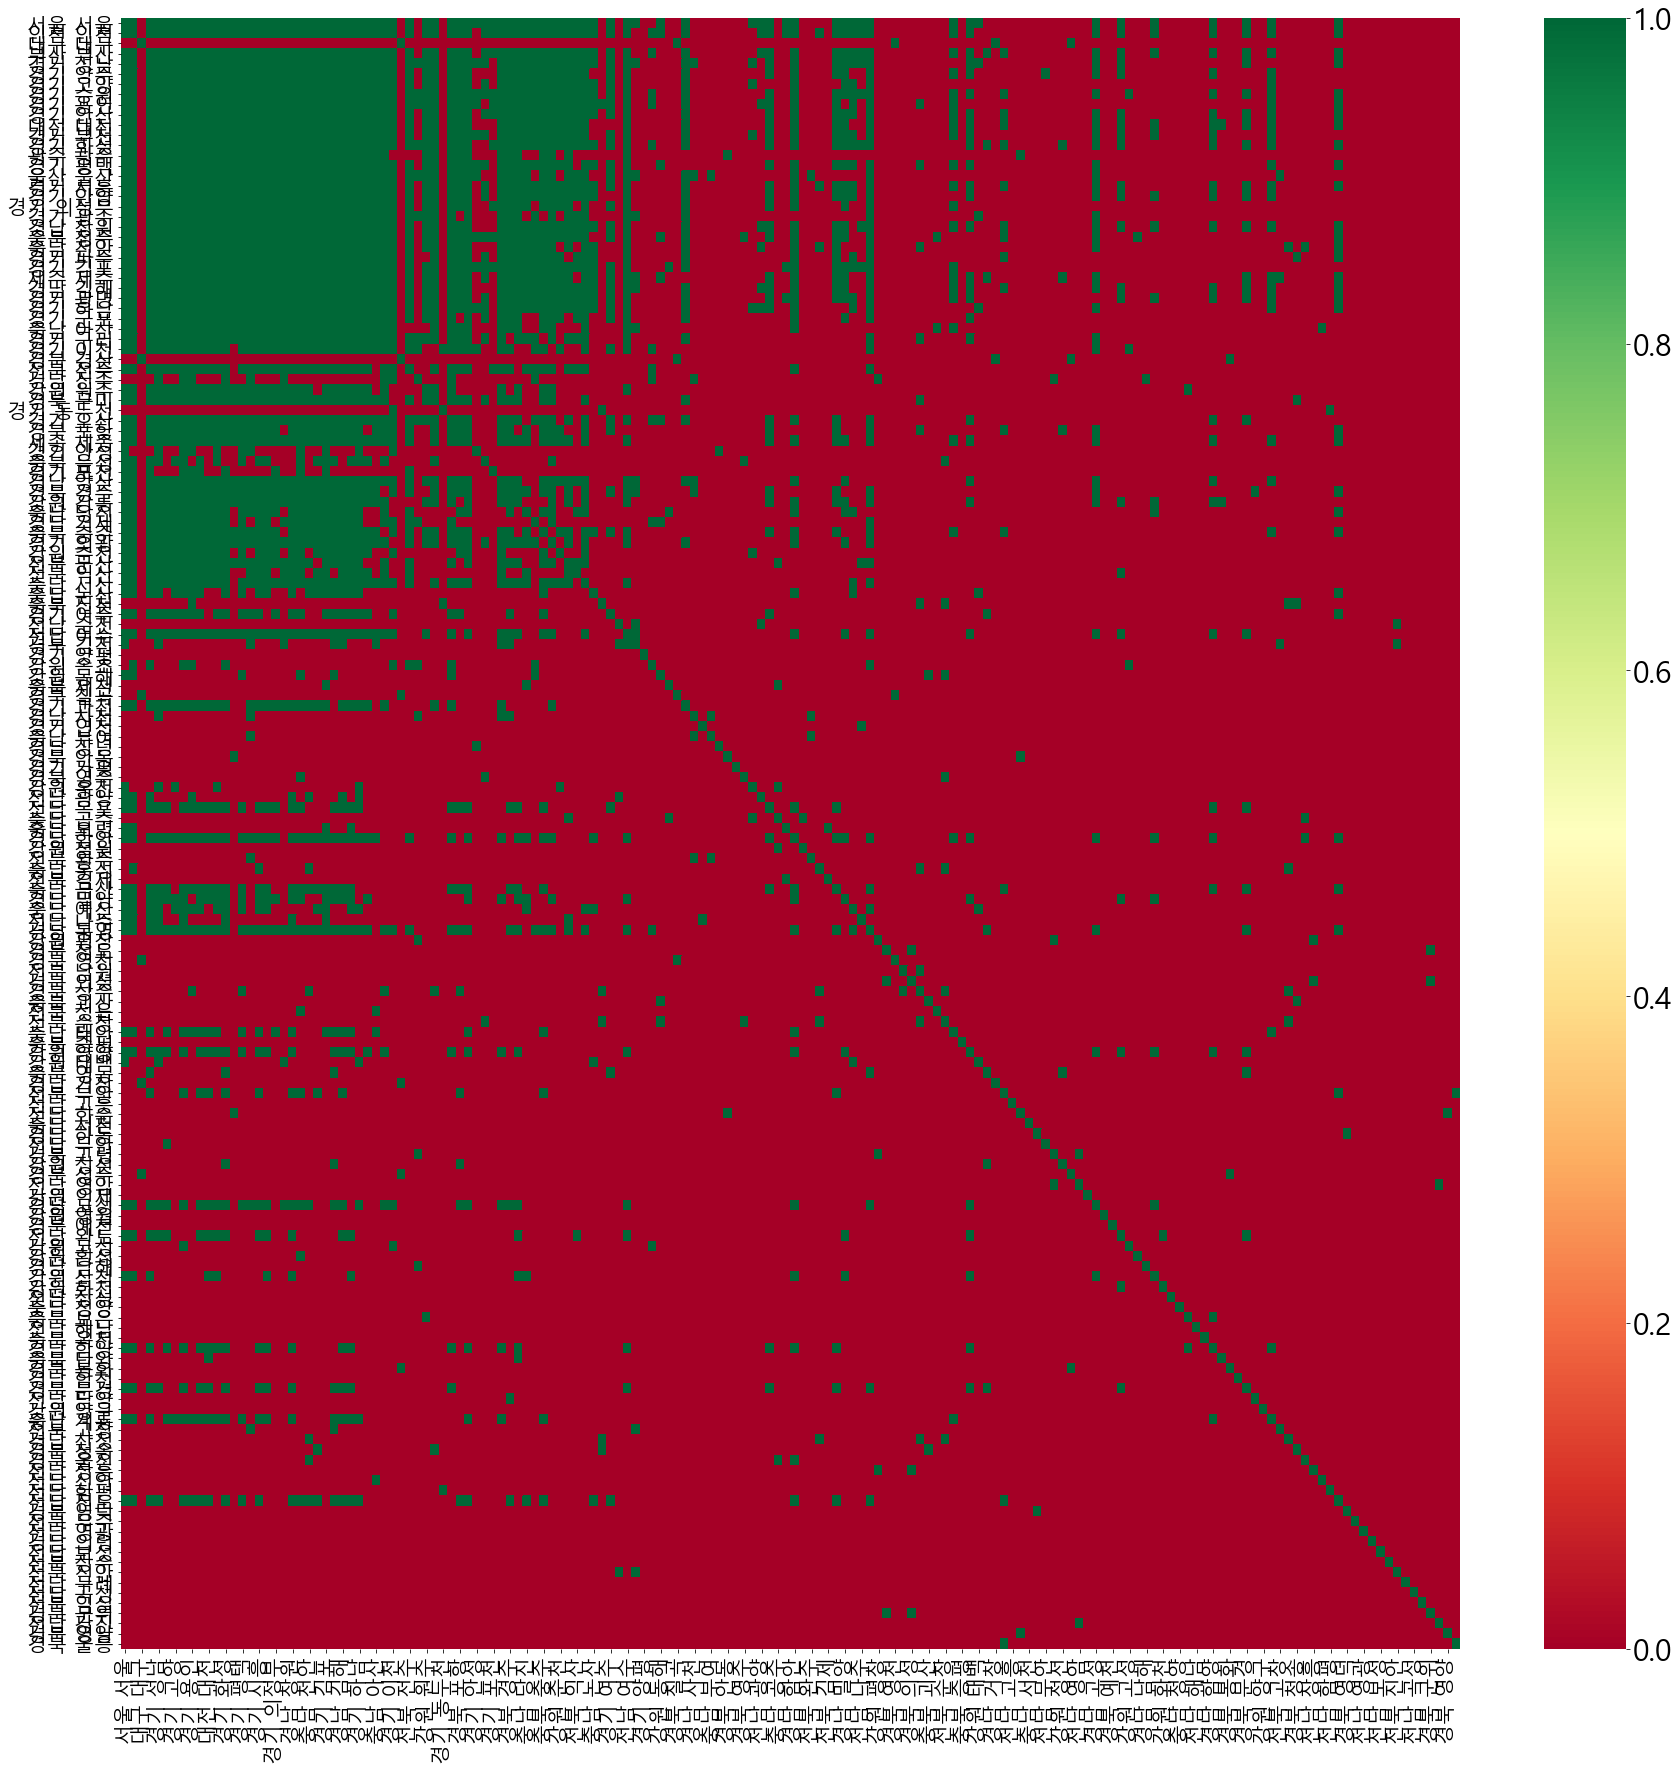

c:\Users\bm990\.julia\conda\3\envs\pytorch_graph\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\bm990\.julia\conda\3\envs\pytorch_graph\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50872 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\bm990\.julia\conda\3\envs\pytorch_graph\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\bm990\.julia\conda\3\envs\pytorch_graph\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 52380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\bm990\.julia\conda\3\envs\pytorch_graph\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Us

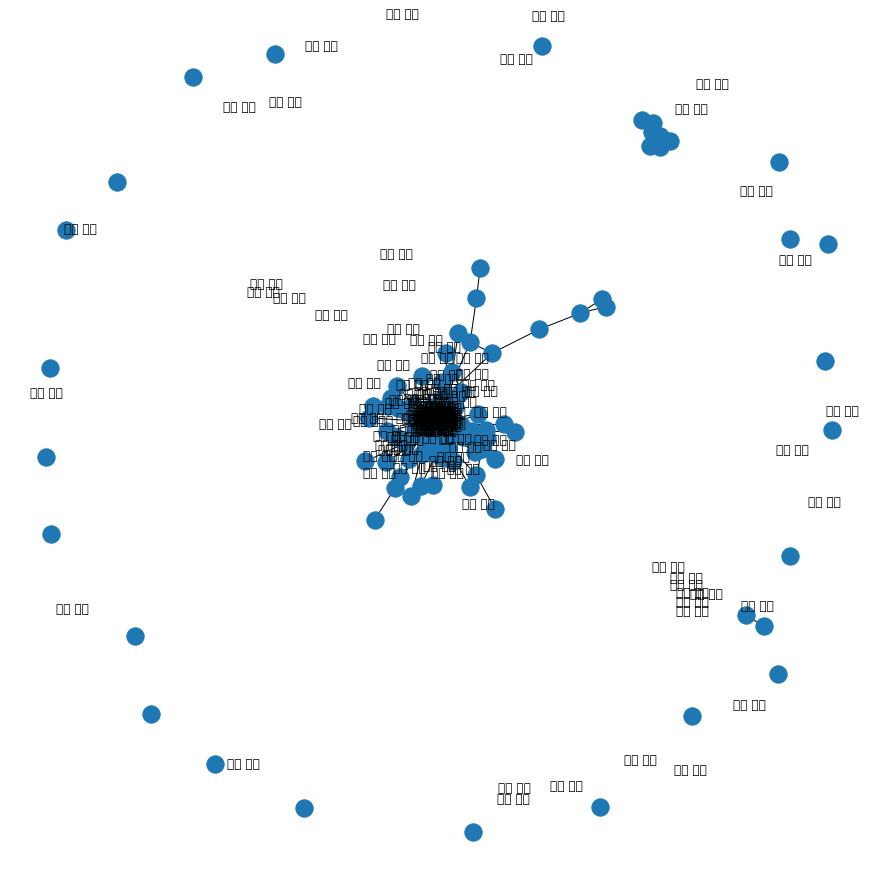

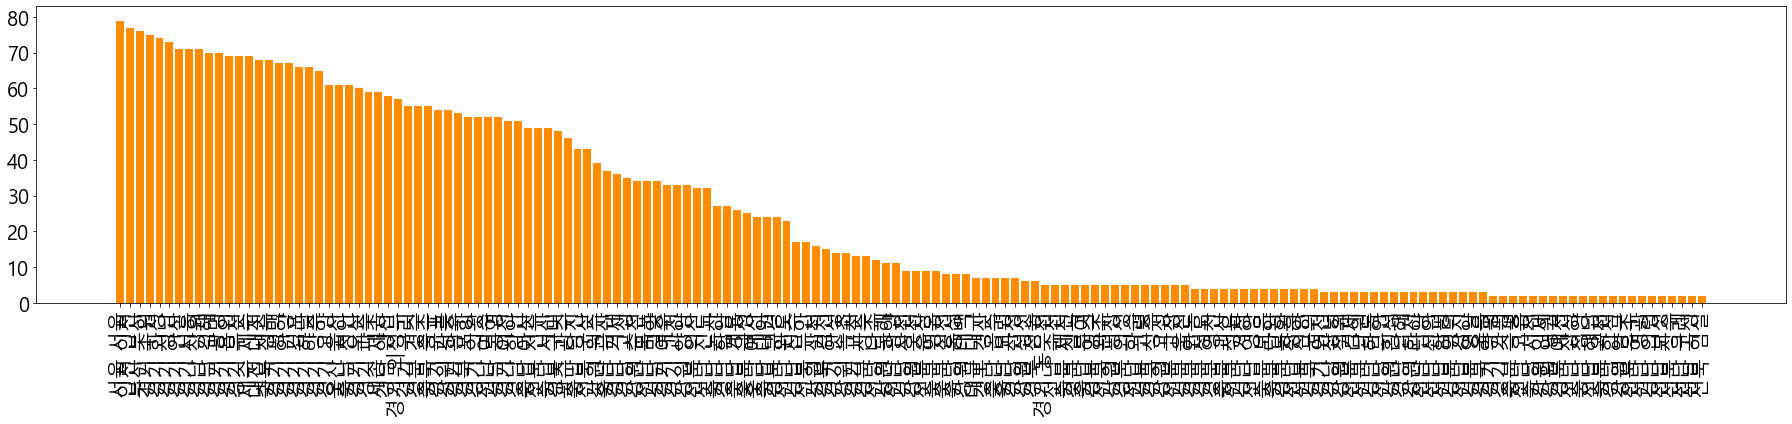

In [5]:
import seaborn as sns
adj_matrix_162 = (daily_df_city.corr(method='pearson') > 0.3).astype(int)
adj_matrix_162

corrmat = daily_df_city.corr()
corrmat = adj_matrix_162
top_corr_features = corrmat.index
plt.figure(figsize=(30,30))
plt.rcParams["font.family"] = 'Malgun Gothic'
g=sns.heatmap(corrmat,cmap="RdYlGn") #annot=True,

cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

plt.yticks(fontsize=20, rotation=0)
plt.xticks(fontsize=20, rotation=90)

import networkx as nx
import matplotlib
G = nx.Graph(corrmat)
A = nx.adjacency_matrix(G)


plt.figure(figsize=(12,12))
nx.draw(G)
# matplotlib.rcParams['font.family'] ='Malgun Gothic'
# matplotlib.rcParams['axes.unicode_minus'] =False
labels = nx.draw_networkx_labels(G, pos=nx.spring_layout(G))
print(G.degree)

from pyvis.network import Network

# nt3 = Network("2000px", "2000px", directed=True, heading= 'state')
# nt3 = net.Network("80%", "80%", directed=False, heading= 'state', bgcolor='#222222', font_color='white')
nt3 = Network("600px", "600px", directed=False, heading= 'state', bgcolor='#222222', font_color='white')

nt3.from_nx(G)
nt3.show_buttons(filter_=['physics'])
nt3.toggle_physics(True)
nt3.show("city.html")

deg_dist = dict(G.degree)
deg_dist = sorted(deg_dist.items(), key = lambda item: item[1], reverse = True)



sorted_x, sorted_y = [],[]
for i in deg_dist:
    sorted_x.append(i[0])
    sorted_y.append(i[1])


plt.figure(figsize=(25,6))
plt.bar(sorted_x, sorted_y, color ='darkorange')
plt.xticks(rotation = 90, fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

In [10]:
G.add_node('서울 서울', asd=2)

In [11]:
G.nodes['서울 서울'] # 이렇게 노드 피처 추가하면 되는구나.

{'size': 10, 'weight': 2, 'asd': 2}

[('인천', 13), ('서울', 14), ('경기', 14), ('전북', 9), ('광주', 2), ('전남', 10), ('대구', 3), ('경북', 3), ('경남', 14), ('충북', 11), ('제주', 12), ('부산', 15), ('세종', 4), ('강원', 11), ('대전', 11), ('울산', 6), ('충남', 12)]


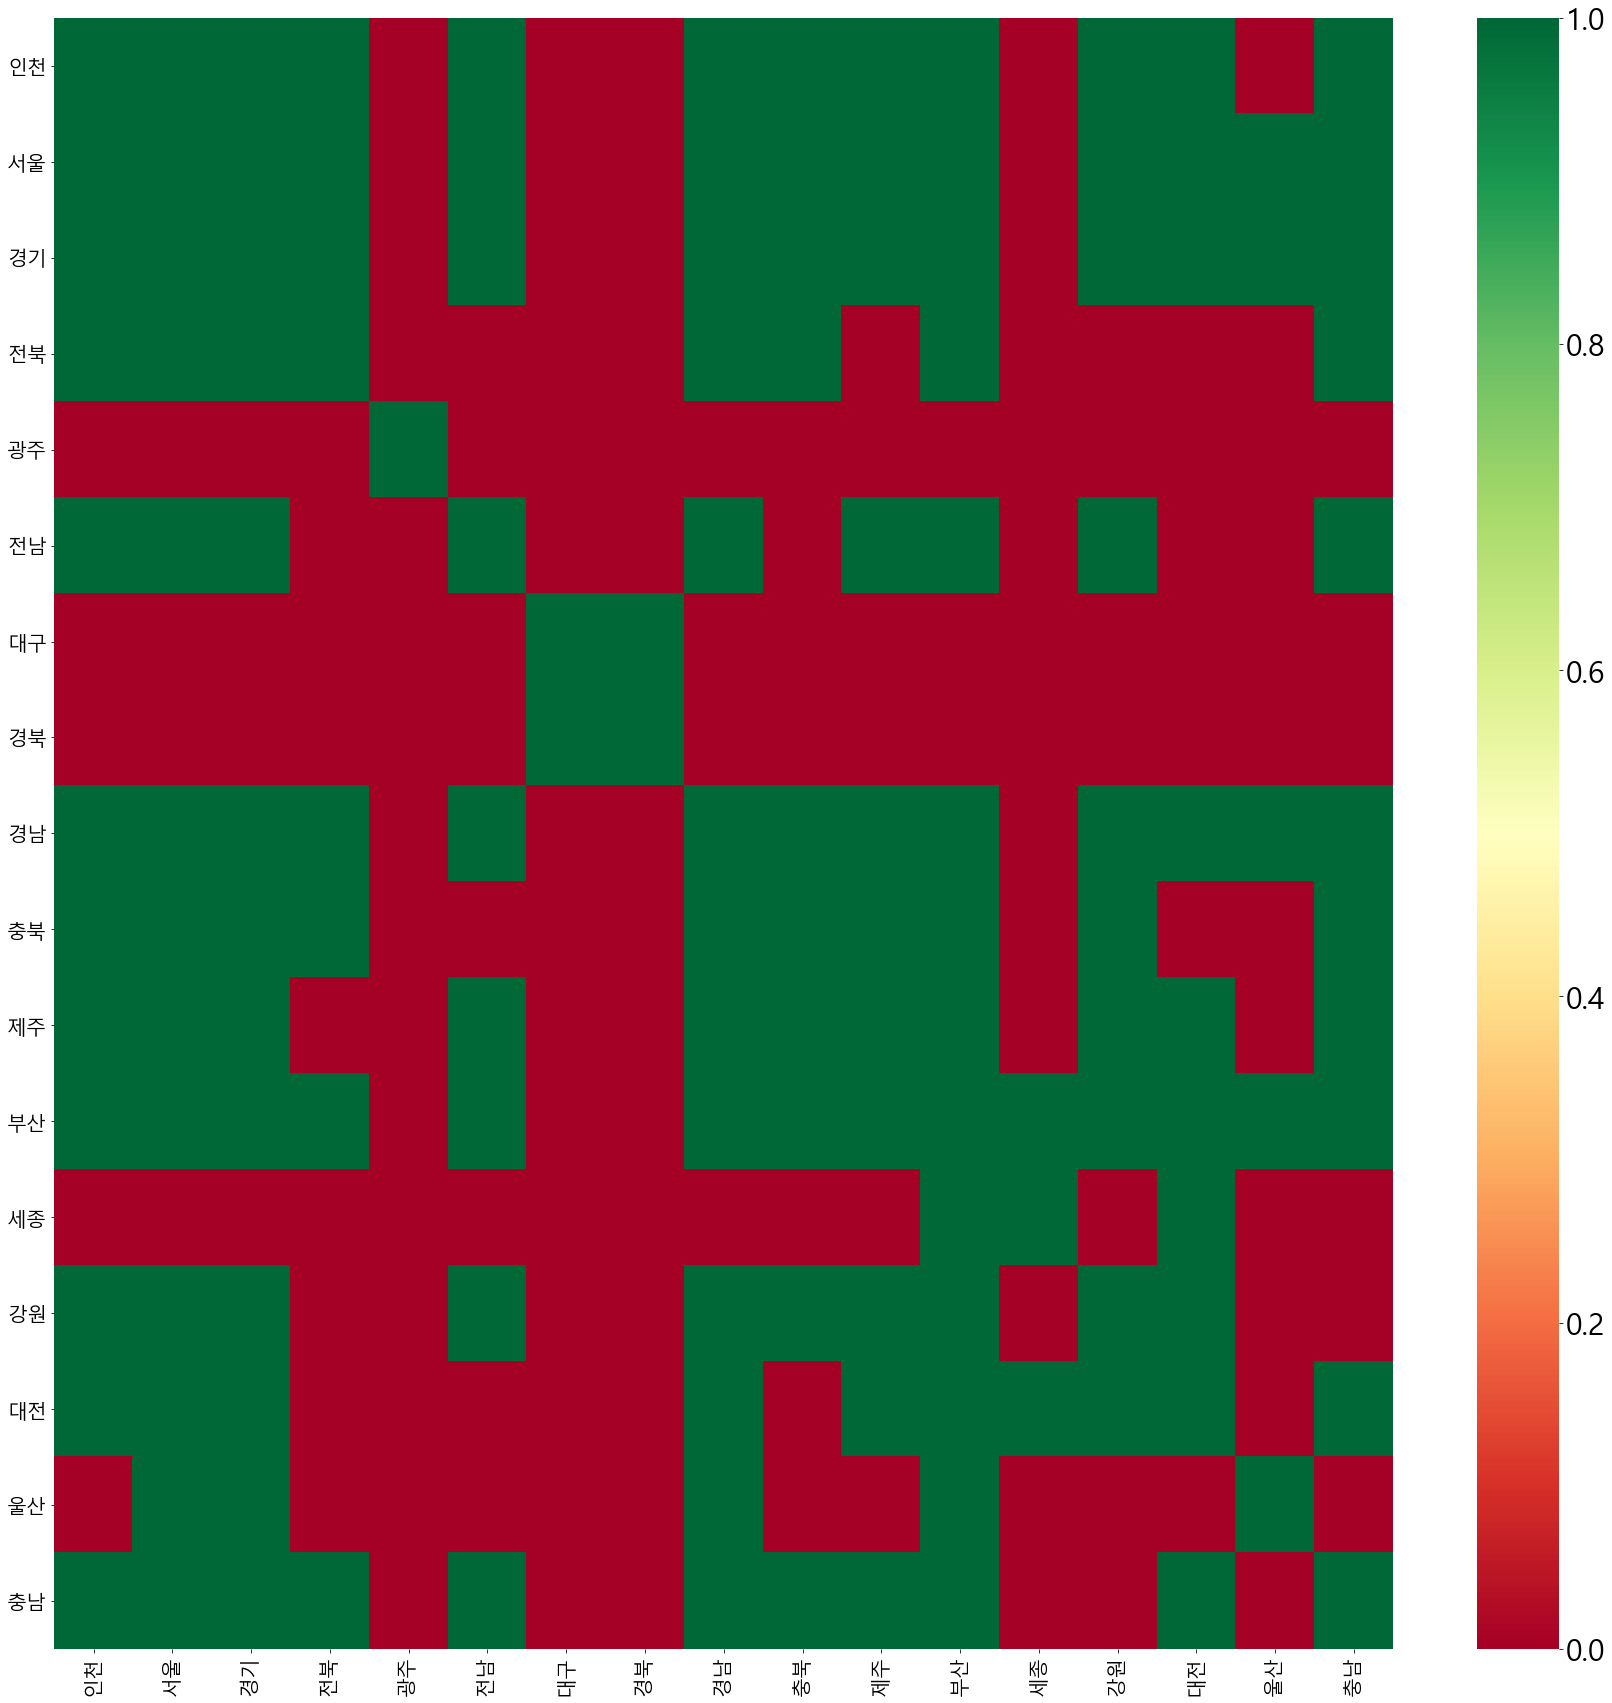

c:\Users\bm990\.julia\conda\3\envs\pytorch_graph\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\bm990\.julia\conda\3\envs\pytorch_graph\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 52380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\bm990\.julia\conda\3\envs\pytorch_graph\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\bm990\.julia\conda\3\envs\pytorch_graph\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50872 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\bm990\.julia\conda\3\envs\pytorch_graph\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Us

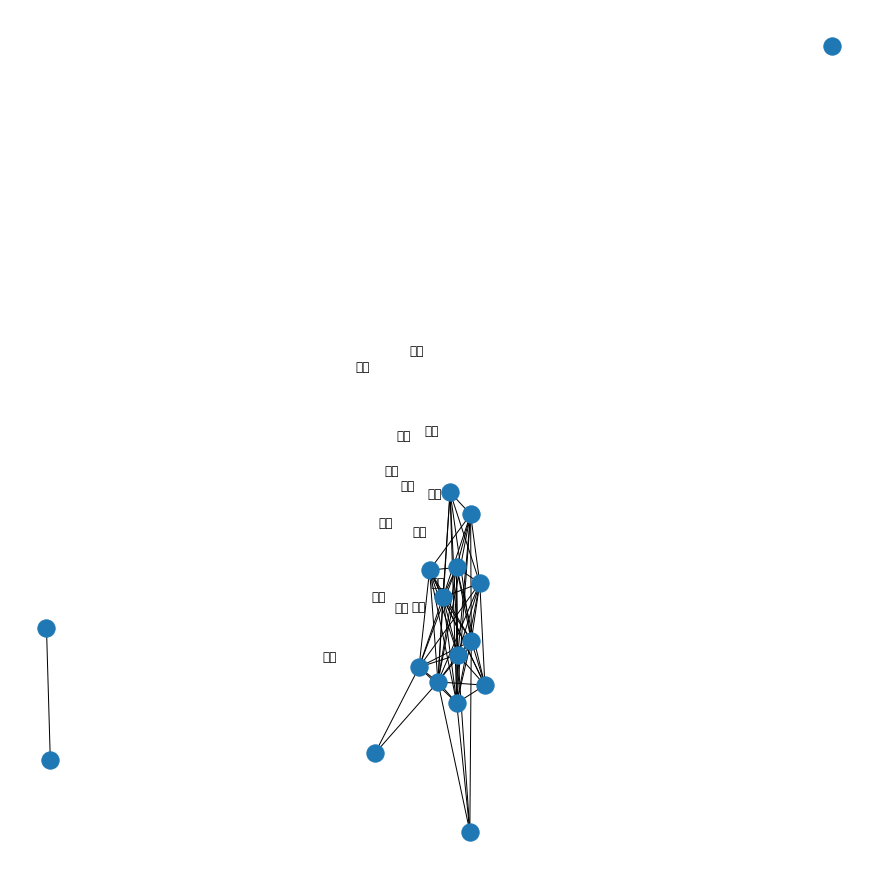

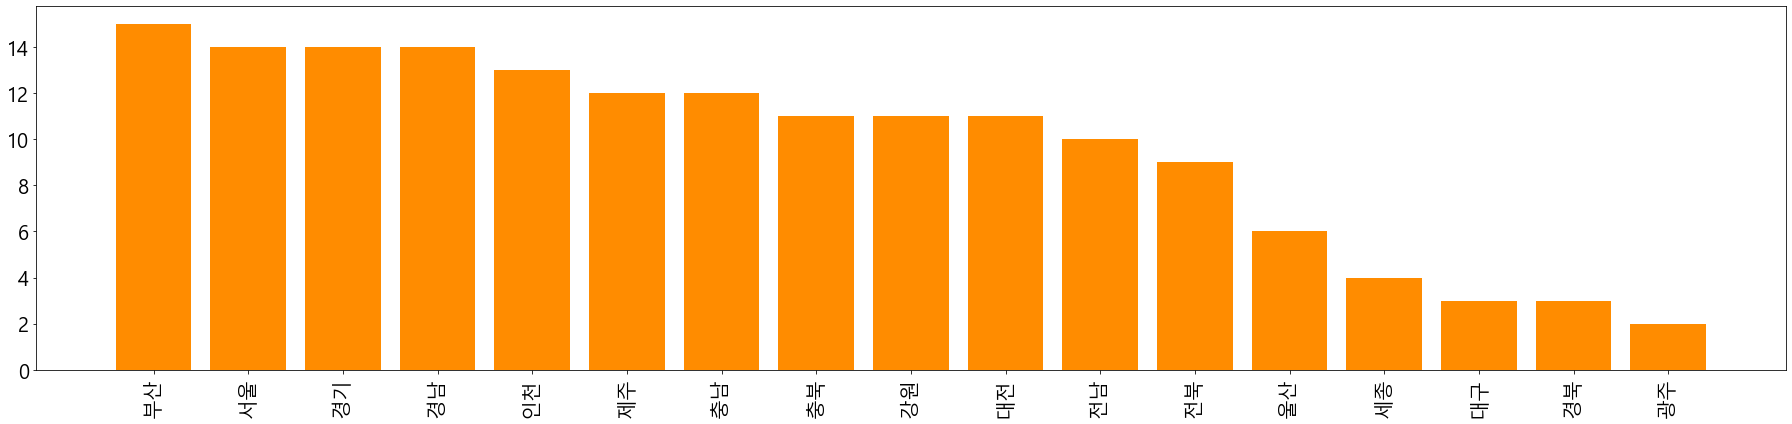

In [13]:
adj_matrix_17 = (daily_df_state.corr(method='pearson') > 0.6).astype(int)
adj_matrix_17

corrmat = daily_df_state.corr()
corrmat = adj_matrix_17
top_corr_features = corrmat.index
plt.figure(figsize=(30,30))
plt.rcParams["font.family"] = 'Malgun Gothic'
g=sns.heatmap(corrmat,cmap="RdYlGn") #annot=True,

cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

plt.yticks(fontsize=20, rotation=0)
plt.xticks(fontsize=20, rotation=90)

import networkx as nx
import matplotlib
G = nx.Graph(corrmat)
A = nx.adjacency_matrix(G)


plt.figure(figsize=(12,12))
nx.draw(G)
# matplotlib.rcParams['font.family'] ='Malgun Gothic'
# matplotlib.rcParams['axes.unicode_minus'] =False
labels = nx.draw_networkx_labels(G, pos=nx.spring_layout(G))
print(G.degree)

from pyvis.network import Network
from pyvis import network as net

# nt3 = Network("2000px", "2000px", directed=True, heading= 'state')
# nt3 = net.Network("80%", "80%", directed=False, heading= 'state', bgcolor='#222222', font_color='white')
nt3 = Network("600px", "600px", directed=False, heading= 'state', bgcolor='#222222', font_color='white')

nt3.from_nx(G)
nt3.show_buttons(filter_=['physics'])
nt3.toggle_physics(True)
nt3.show("state.html")

deg_dist = dict(G.degree)
deg_dist = sorted(deg_dist.items(), key = lambda item: item[1], reverse = True)



sorted_x, sorted_y = [],[]
for i in deg_dist:
    sorted_x.append(i[0])
    sorted_y.append(i[1])


plt.figure(figsize=(25,6))
plt.bar(sorted_x, sorted_y, color ='darkorange')
plt.xticks(rotation = 90, fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

마크다운

In [ ]:
# 데이터 전처리
infection = pd.DataFrame({})#{'서울' : pd.DataFrame({})}
pre_data = pd.DataFrame({})
Monthly_tmp = {}
unlinked_ratio = []
region_list = ['인천','서울','경기', '전북', '광주', '전남', '대구', '경북', '경남', '충북', '제주', '부산', '세종', '강원', '대전', '울산', '충남']#, '검역소']


diff_days = datetime.date(2021,10,15) - datetime.date(2020,1,19)
date_list = []
for i in range(diff_days.days):
    date_list.append(datetime.date(2020, 1, 19) + timedelta(days=i))
    
date_df = pd.DataFrame({'date' : date_list})


for i in range(1): 
    data_1 = pd.read_csv('대한수학회 공유확진자DB_220321_' + str(i+1) + '.csv', low_memory=False)

    data_1 = data_1[['거주시군구', '거주시도', '발병일', '신고일', '연령', '위중증 유무(유:1)', '사망유무(유:1)', '선행확진자_번호']]
    data_1 = data_1.fillna(0)
    data_1['신고일'] = pd.to_datetime(data_1['신고일'], format="%Y-%m-%d")
    data_1['신고일'] = data_1['신고일'][data_1['신고일'] >= pd.to_datetime('2020-01-19', format="%Y-%m-%d")]
    data_1['신고일'] = data_1['신고일'][data_1['신고일'] <= pd.to_datetime('2021-10-15', format="%Y-%m-%d")]
    
    data_1['확진자'] = [1]*len(data_1)
    # data_1['위중증또는사망'] = [0]*len(data_1)
    # data_1['위중증또는사망'][(data_1['위중증 유무(유:1)']==1) | (data_1['사망유무(유:1)']==1)] = 1

    data_1 = data_1[data_1['거주시도'] != 0] 
    # region_list = list(Counter(data_1['거주시도']).keys())
    region_group = dict(list(data_1.groupby(data_1['거주시도'])))
    
    
    total_df = pd.DataFrame({})
    for j in range(len(region_list)):
        region_group[region_list[j]]['신고일'] = region_group[region_list[j]]['신고일'].apply(lambda x: x.date())
        test_df = pd.concat([region_group[region_list[j]], date_df], ignore_index=True)
        test_df = test_df.sort_values(by='신고일')
        # test_df['time_idx'] = [i for i in range(len(test_df))]
        test_df['거주시도'] = region_list[j]
        test_df = test_df.fillna(0)
        
        pre_df = pd.DataFrame({})
        tmp_df = pd.DataFrame({})
        
        tmp_df['date'] = region_group[region_list[j]]['신고일']
        # tmp_df['date'] = tmp_df['date'].apply(lambda x: x.date())

        pre_df['date'] = tmp_df['date'].value_counts().index
        pre_df['value'] = tmp_df['date'].value_counts().values

        pre_df = pd.merge(pre_df,date_df,how='outer') # date 없는 값을 NaN으로 채워서 합치기 https://mindscale.kr/course/pandas-basic/merge/
        pre_df = pre_df.sort_values(by='date') # date 기준으로 sort
        pre_df = pre_df.fillna(0) # 빈 값 0으로 채우기
        pre_df['time_idx'] = [i for i in range(len(pre_df))]
        pre_df['value'] = pre_df['value'].astype(int)
        # 지역 번호
        pre_df['region_idx'] = j
        
        total_df = pd.concat([total_df, pre_df])
        total_df.index = [i for i in range(len(total_df))] # merge하면서 뒤죽박죽인 index를 다시 0부터
        # pre_df['unlinked_ratio'] = []
        # pre_df['asym_ratio'] = []
        for k in total_df['date'][total_df['region_idx'] == j].index:
            if total_df['date'][k] not in test_df['신고일']:
                unlinked_ratio.append(0)
            
            else:
                print(1)
                ext_df = test_df[test_df['신고일'] == total_df['date'][k]]
                unlinked = Counter(ext_df['선행확진자_번호'][ext_df['거주시도'] == region_list[j]])[0]
                unlinked_ratio.append(unlinked/len(test_df['거주시도'] == region_list[j]))
                
        


In [ ]:
total_df['date'][k] #not in test_df['신고일']

In [ ]:
total_df['unlinked'] = unlinked_ratio

In [ ]:
total_df

In [ ]:
len(unlinked_ratio)

In [ ]:
import pandas as pd

df = pd.DataFrame({'a' : [1,2,3,4],
              'b' : [3,4,5,6]})

In [ ]:
df.loc[:,['a','b']][df['a']==4]

In [ ]:
total_df.to_csv('deepAR_covid_test.csv')

In [ ]:
total_df

In [ ]:
total_df['value'][total_df['region_idx'] == 0].plot()
total_df['value'][total_df['region_idx'] == 1].plot()
total_df['value'][total_df['region_idx'] == 2].plot()

In [ ]:
total_df

In [ ]:
total_df[total_df['value'] == 519]

In [ ]:
pre_df = pd.DataFrame({})
tmp_df = pd.DataFrame({})
tmp_df['date'] = region_group['강원']['신고일']
tmp_df['date'] = tmp_df['date'].apply(lambda x: x.date())

pre_df['date'] = tmp_df['date'].value_counts().index
pre_df['values'] = tmp_df['date'].value_counts().values

pre_df = pd.merge(pre_df,date_df,how='outer') # date 없는 값을 NaN으로 채워서 합치기 https://mindscale.kr/course/pandas-basic/merge/
pre_df = pre_df.sort_values(by='date') # date 기준으로 sort
pre_df = pre_df.fillna(0) # 빈 값 0으로 채우기
pre_df['time_idx'] = [i for i in range(len(pre_df))]
pre_df['values'] = pre_df['values'].astype(int)
# 지역 번호
pre_df['region_idx'] = 1
pre_df.index = [i for i in range(len(pre_df))] # merge하면서 뒤죽박죽인 index를 다시 0부터
# pre_df['unlinked_ratio'] = []
# pre_df['asym_ratio'] = []


In [ ]:
pre_df

In [ ]:
# 누적 확진자 계산
for region in region_list:
    
    for idx in infection['인천'].index:
        if idx not in infection[region].index:
            infection[region].loc[idx] = [0, 0, 0, 0, 0]
            
    
    infection[region] = infection[region].reindex(index = infection['인천'].index)    
    infection[region]['누적확진자'] = [0 for _ in range(len(infection['인천']))]
    infection[region]['누적위중증'] = [0 for _ in range(len(infection['인천']))]
    
    prior_cum = 0
    prior_cum_sev = 0
    
    for date in infection['인천'].index: # 전체 인덱스 포함되어있는거 인천으로 임의지정
        if '202001' in date:
            # 누적 확진자 초기값
            infection[region].loc[date, '누적확진자'] = infection[region].loc[date, '확진자']
            prior_cum = infection[region].loc[date, '확진자']
            
            # 누적 위중증, 사망
            infection[region].loc[date, '누적위중증'] = infection[region].loc[date, '위중증또는사망']
            prior_cum_sev = infection[region].loc[date, '위중증또는사망']
            
        else:
            # 누적 확진자
            infection[region].loc[date, '누적확진자'] = infection[region].loc[date, '확진자'] + prior_cum
            prior_cum = infection[region].loc[date, '누적확진자']
            
            # 누적 위중증, 사망
            infection[region].loc[date, '누적위중증'] = infection[region].loc[date, '위중증또는사망'] + prior_cum_sev
            prior_cum_sev = infection[region].loc[date, '누적위중증']
            
    
    infection[region] = infection[region].astype(int)

In [ ]:
# Daily
for region in region_list:
    fig, ax = plt.subplots(figsize=(10,5))
    # infection[region] = infection[region].drop(['197001'])
    # infection[region][['위중증 유무(유:1)', '사망유무(유:1)']].plot.bar(width=0.8, ax = ax)
    # infection[region]['치명률'].plot.bar(width=0.8, ax = ax)
    infection[region]['치명률'].plot(linewidth=2, ax = ax)
    infection[region]['확진자'].plot(secondary_y=True, color = '#BC3C29FF', linewidth=2, ax = ax)
    
    # ax.set_xticklabels(infection[region].index, rotation=45)
    ax.set_ylim(0, 0.16)
    ax.right_ax.set_ylim(0,max(infection[region]['확진자']))
    ax.set_title(str(region), fontsize=25)
    ax.right_ax.set_ylabel('확진자 수')
    ax.set_ylabel('치명률')
    # ax2 = ax.twinx()
    # ax2.set_ylabel('확진자 수')
    plt.savefig('tosubmit/' + region + '_Monthly.png')
    
# Cum

for region in region_list:
    fig, ax = plt.subplots(figsize=(10,5))
    infection[region]['누적위중증'].plot(linewidth=2, ax = ax)
    infection[region]['누적확진자'].plot(secondary_y=True, color = '#BC3C29FF', linewidth=2, ax = ax)
    
    # ax.set_xticklabels(infection[region].index, rotation=45)
    # ax.set_ylim(0, 0.16)
    ax.right_ax.set_ylim(0,max(infection[region]['누적확진자']))
    ax.set_title(str(region), fontsize=25)
    ax.right_ax.set_ylabel('누적확진자')
    ax.set_ylabel('누적위중증')
    plt.savefig('tosubmit/' + region + '_Monthly_cum.png')

In [ ]:
pd.DataFrame(infection['인천'])

In [ ]:
import json
# 경위도 json 파일 로드 
geo_path = '__original_json_file_path__'
f = open(geo_path, encoding='ANSI')
geo_json = json.loads(f.read())

sido_list = []

def convert_yx(lon_lat):
    lat_lon = []
    for x,y in lon_lat:
        temp = x
        x = y
        y = temp
        lat_lon.append([x,y])
    return lat_lon
    

for i in range(17):
    lon_lat = sum(geo_json['features'][i]['geometry']['coordinates'], [])

    lat_lon = []
    
    try: # 쪼개지지 않고 하나의 덩어리로 그려지는 도시들 
        sido_list.append(convert_yx(lon_lat))

    except: # 여러개로 쪼개지는 형태의 도시들
        new_sido = []
        sido = sum(geo_json['features'][i]['geometry']['coordinates'], []) 
        for sido_pice in sido: 
            new_pice = []
            new_sido.append(convert_yx(sido_pice)) 
            
        sido_list.append(new_sido)

# geometry에 변환된 경위도 값  넣어주기 
for i in range(17):
    geo_json['features'][i]['geometry']['coordinates'] = sido_list[i]

# 저장 
with open('__save_path__','w', encoding='ANSI') as make_file:
    json.dump(geo_json, make_file, indent="\t")

In [ ]:
import folium
import json

m = folium.Map(location=[36, 127],  tiles="Mapbox Bright", zoom_start=7)

path = '__json_file_path__' # 위에서 얻은 json 파일 경로
f = open(path, encoding='ANSI') 
json = json.loads(f.read())


for i in range(17):
    folium.Polygon(
        locations =  json['features'][i]['geometry']['coordinates'], # foligon 사용 예시 
        fill = True,
    ).add_to(m)

m.save('__save_path__.html')     

In [ ]:
infection = {}#{'서울' : pd.DataFrame({})}
Monthly_tmp = {}

region_list = ['인천','서울','경기', '전북', '광주', '전남', '대구', '경북', '경남', '충북', '제주', '부산', '세종', '강원', '대전', '울산', '충남']#, '검역소']
for i in [1,2,3,4,5]: 
    data_1 = pd.read_csv('대한수학회 공유확진자DB_220321_' + str(i+1) + '.csv', low_memory=False)

    data_1 = data_1[['거주시군구', '거주시도', '신고일', '위중증 유무(유:1)', '사망유무(유:1)']]
    data_1 = data_1.fillna(0)
    data_1['신고일'] = pd.to_datetime(data_1['신고일'], format="%Y-%m-%d")
    data_1['신고일'] = data_1['신고일'][data_1['신고일'] >= pd.to_datetime('2021-12-22', format="%Y-%m-%d")]
    data_1['신고일'] = data_1['신고일'][data_1['신고일'] <= pd.to_datetime('2022-02-28', format="%Y-%m-%d")]
    
    data_1['확진자'] = [1]*len(data_1)
    data_1['위중증또는사망'] = [0]*len(data_1)
    data_1['위중증또는사망'][(data_1['위중증 유무(유:1)']==1) | (data_1['사망유무(유:1)']==1)] = 1
    
    data_1 = data_1[data_1['거주시도'] != 0] 
    # region_list = list(Counter(data_1['거주시도']).keys())
    region_group = dict(list(data_1.groupby(data_1['거주시도'])))


    for region in region_list:
        # sum_ = sum(region_group[region]['위중증 유무(유:1)']) + sum(region_group[region]['사망유무(유:1)'])
        sum_ = sum(region_group[region]['위중증또는사망']) # 위중증 또는 사망으로 수정
        inf_ = len(region_group[region])
        Monthly_data = data_1.groupby(data_1['신고일'][data_1['거주시도'] == region].dt.strftime("%Y%m%w")).sum()
        # Monthly_data['치명률'] = (Monthly_data['위중증 유무(유:1)'] + Monthly_data['사망유무(유:1)']) / Monthly_data['확진자']
        Monthly_data['치명률'] = (Monthly_data['위중증또는사망']) / Monthly_data['확진자']

        if i > 2:
            Monthly_data = Monthly_data.add(infection[region], fill_value=0)

        infection[region] = Monthly_data
        # print(infection[region])

In [ ]:
for region in region_list:
    fig, ax = plt.subplots(figsize=(10,5))
    # infection[region] = infection[region].drop(['197001'])
    # infection[region][['위중증 유무(유:1)', '사망유무(유:1)']].plot.bar(width=0.8, ax = ax)
    infection[region]['치명률'].plot.bar(width=0.8, ax = ax)
    
    infection[region]['확진자'].plot(secondary_y=True, color = '#BC3C29FF', linewidth=2, ax = ax)
    ax.right_ax.set_ylim(0,max(infection[region]['확진자']))
    ax.set_title(str(region), fontsize=25)
    ax.set_xticklabels(infection[region].index, rotation=45)
    plt.savefig(region + '_Monthly2.png')

In [ ]:
infection = {}#{'서울' : pd.DataFrame({})}
Monthly_tmp = {}

region_list = ['인천','서울','경기', '전북', '광주', '전남', '대구', '경북', '경남', '충북', '제주', '부산', '세종', '강원', '대전', '울산', '충남']#, '검역소']
for i in range(2): 
    data_1 = pd.read_csv('대한수학회 공유확진자DB_220321_' + str(i+1) + '.csv', low_memory=False)

    data_1 = data_1[['거주시군구', '거주시도', '신고일', '위중증 유무(유:1)', '사망유무(유:1)']]
    data_1 = data_1.fillna(0)
    data_1['신고일'] = pd.to_datetime(data_1['신고일'], format="%Y-%m-%d")
    data_1['신고일'] = data_1['신고일'][data_1['신고일'] >= pd.to_datetime('2020-01-19', format="%Y-%m-%d")]
    data_1['신고일'] = data_1['신고일'][data_1['신고일'] <= pd.to_datetime('2021-12-21', format="%Y-%m-%d")]
    
    data_1['확진자'] = [1]*len(data_1)
    data_1['위중증또는사망'] = [0]*len(data_1)
    data_1['위중증또는사망'][(data_1['위중증 유무(유:1)']==1) | (data_1['사망유무(유:1)']==1)] = 1

    data_1 = data_1[data_1['거주시도'] != 0] 
    # region_list = list(Counter(data_1['거주시도']).keys())
    region_group = dict(list(data_1.groupby(data_1['거주시도'])))


    for region in region_list:
        # sum_ = sum(region_group[region]['위중증 유무(유:1)']) + sum(region_group[region]['사망유무(유:1)']) # 위중증 또는 사망으로 수정
        sum_ = sum(region_group[region]['위중증또는사망']) # 위중증 또는 사망으로 수정
        inf_ = len(region_group[region])
        Monthly_data = data_1.groupby(data_1['확진자'][data_1['거주시도'] == region]).sum()
        # Monthly_data['치명률'] = (Monthly_data['위중증 유무(유:1)'] + Monthly_data['사망유무(유:1)']) / Monthly_data['확진자']
        Monthly_data['치명률'] = (Monthly_data['위중증또는사망']) / Monthly_data['확진자']

        if i > 0:
            Monthly_data = Monthly_data.add(infection[region], fill_value=0)

        infection[region] = Monthly_data
        # print(infection[region])